# Inspiration

- Basic Keras implementation: https://www.kaggle.com/bguberfain/naive-keras

- High-level image segmentation example: https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef

- Even more high-level example: https://towardsdatascience.com/semantic-segmentation-with-deep-learning-a-guide-and-code-e52fc8958823




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm import tqdm_notebook
import cv2
from sklearn.model_selection import train_test_split


In [2]:
input_folder = join('input')

df_mask = pd.read_csv(join(input_folder, 'train_masks.csv'), usecols=['img'])
ids_train = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

imgs_idx = list(range(1, 17))

print("There are %d unique images and %d unique cars" % (len(df_mask),len(ids_train)))

There are 5088 unique images and 318 unique cars


In [28]:
load_img = lambda im, idx: cv2.imread(join(input_folder, 'train', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join(input_folder, 'train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))

#resize(src, dst, Size(), 0.5, 0.5, interpolation);
def resize(im):
    return cv2.resize(im, (0,0), fx=0.25, fy=0.25)

#resize = lambda im: downscale_local_mean(im, (4,4) if im.ndim==2 else (4,4,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))

In [9]:
print("Dimension of each image is", load_img(ids_train[0], 1).shape)

Dimension of each image is (1280, 1918, 3)


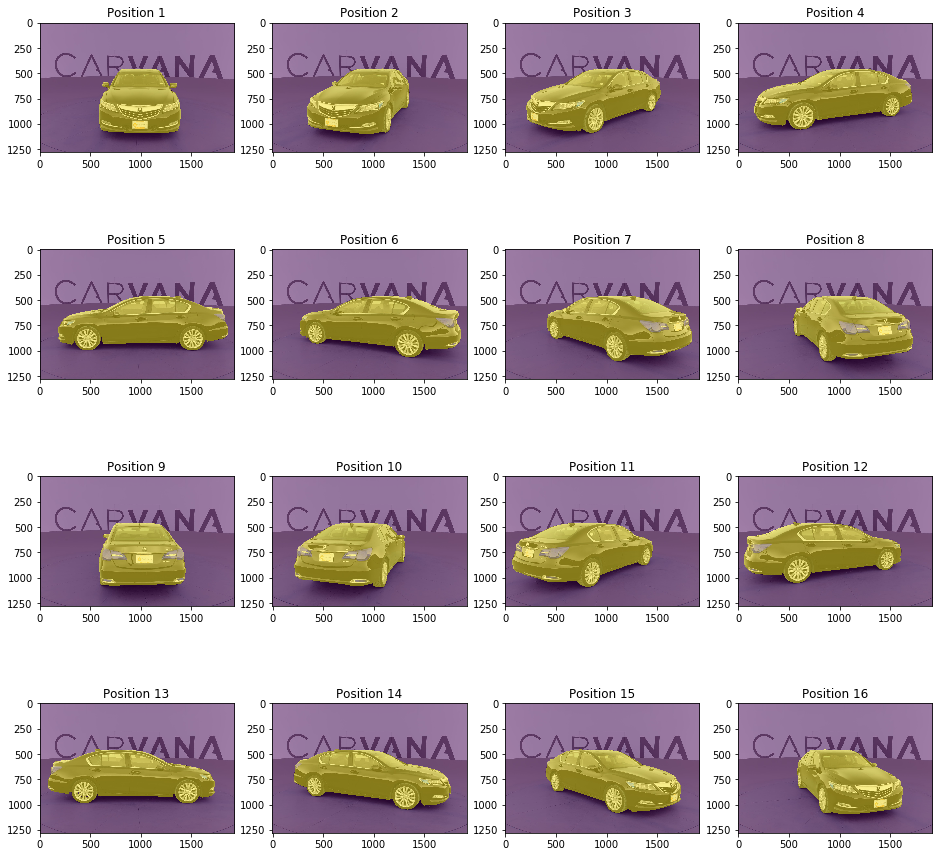

In [10]:
# Let's display a single car and mask

fig, ax = plt.subplots(4,4, figsize=(16, 16))
ax = ax.ravel()

for i in imgs_idx:
    ax[i-1].imshow(load_img(ids_train[0], i))
    ax[i-1].imshow(load_mask(ids_train[0], i), alpha = 0.5)
    ax[i-1].set_title('Position {}'.format(i))


In [27]:
# Seems like there is a lot of rotational symmetry e.g. #2 and #17, 
# although the pictures are not exact copies of each other (you can see from the background text)

In [94]:
# Preprocessing - loading all the training images, downscaling and concatenating into one 4D array

num_train = 150

X = np.empty((num_train*16, 320, 480, 3), dtype=np.float32)
y = np.empty((num_train*16, 320, 480, 1), dtype=np.float32)

with tqdm_notebook(total=num_train*16) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        for j in imgs_idx:
            X[i*16+j-1, ...] = resize(load_img(img_id, j)) / 255.
            y_temp = resize(load_mask(img_id, j)) / 255.
            y[i*16+j-1] = y_temp[..., np.newaxis]
            bar.update()
                                        
                                        
#norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


In [95]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras import backend as K

model = Sequential()

model.add (Conv2D(16, 3, activation='relu', padding='same', input_shape=(320, 480, 3) ))
model.add ( MaxPooling2D((2, 2), padding='same') )
model.add ( Conv2D(32, (3, 3), activation='relu', padding='same') )
model.add ( MaxPooling2D((2, 2), padding='same') )
model.add ( Conv2D(64, (3, 3), activation='relu', padding='same') )
model.add ( MaxPooling2D((2, 2), padding='same') )

model.add ( Conv2D(64, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(32, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(16, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(1, (3, 3), activation='sigmoid', padding='same') )

In [107]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 320, 480, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 160, 240, 16)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 160, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 80, 120, 32)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 80, 120, 64)       18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 40, 60, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 40, 60, 64)        36928     
__________

In [108]:
history = model.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val), batch_size=5, verbose=2) #, 
                    #callbacks=[keras_utils.TqdmProgressCallback()])

Train on 1920 samples, validate on 480 samples
Epoch 1/15
1920/1920 [==============================] - 995s 518ms/step - loss: -0.7043 - acc: 0.9312 - dice_coef: 0.8057 - val_loss: -0.8696 - val_acc: 0.9693 - val_dice_coef: 0.9143
Epoch 2/15
1920/1920 [==============================] - 984s 513ms/step - loss: -0.8835 - acc: 0.9726 - dice_coef: 0.9254 - val_loss: -0.9159 - val_acc: 0.9797 - val_dice_coef: 0.9453
Epoch 3/15
1920/1920 [==============================] - 981s 511ms/step - loss: -0.9187 - acc: 0.9805 - dice_coef: 0.9479 - val_loss: -0.9345 - val_acc: 0.9838 - val_dice_coef: 0.9583
Epoch 4/15
1920/1920 [==============================] - 993s 517ms/step - loss: -0.9369 - acc: 0.9846 - dice_coef: 0.9596 - val_loss: -0.9334 - val_acc: 0.9840 - val_dice_coef: 0.9587
Epoch 5/15
1920/1920 [==============================] - 1113s 580ms/step - loss: -0.9445 - acc: 0.9863 - dice_coef: 0.9644 - val_loss: -0.9531 - val_acc: 0.9882 - val_dice_coef: 0.9700
Epoch 6/15
  50/1920 [..........

KeyboardInterrupt: 

In [109]:
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()

NameError: name 'history' is not defined

In [110]:
model.save('my_model.h5')

Text(0.5,1,'y_pred')

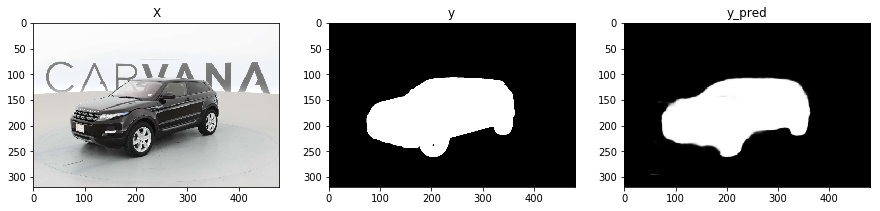

In [117]:
idx = 20
x = X_val[idx]

fig, ax = plt.subplots(1,3, figsize=(15,10))
ax = ax.ravel()

ax[-3].imshow(x)
ax[-3].set_title('X')

ax[-2].imshow(y_val[idx,...,0], cmap='gray')
ax[-2].set_title('y')

y_pred = model.predict(x[None]).squeeze()
ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred')

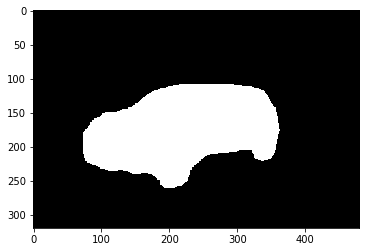

In [118]:
plt.imshow(y_pred > 0.5, cmap='gray')

In [119]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

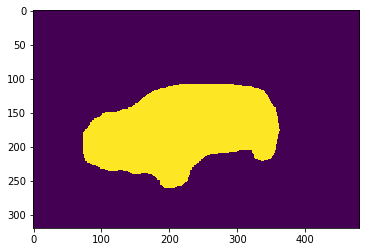

In [120]:
res = np.where(y_pred > 0.5, 1, 0)

# Testing encoding and decoding
res2 = rle_encode(res)
plt.imshow(rle_decode(res2, (320, 480)))

In [121]:
df_mask = pd.read_csv(join(input_folder, 'sample_submission.csv'), usecols=['img'])
ids_test = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

imgs_idx = list(range(1, 17))

print("There are %d unique images and %d unique cars in the test set" % (len(df_mask),len(ids_test)))

There are 100064 unique images and 6254 unique cars in the test set


Text(0.5,1,'y_pred (test set)')

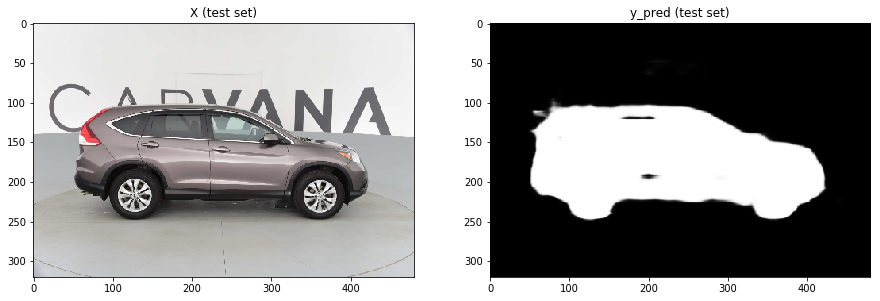

In [130]:
load_test_img = lambda im, idx: imread(join(input_folder, 'test', '{}_{:02d}.jpg'.format(im, idx)))
            
def prepare_img(im, idx):
    
    return (resize(load_test_img(im, idx)) / 255.)
 
def predict_img_rle(X):
    y_pred = model.predict(X[None]).squeeze()
    y_pred = np.float32(np.where(y_pred > 0.5, 1, 0))
        
    # Upscale 4X on each axis
    return rle_encode(cv2.resize(y_pred, (0,0), fx=4, fy=4, interpolation=cv2.INTER_LINEAR))

X = prepare_img(ids_test[66], 13)
y_pred = model.predict(X[None]).squeeze()

fig, ax = plt.subplots(1,2, figsize=(15,10))
ax = ax.ravel()

ax[-2].imshow(X)
ax[-2].set_title('X (test set)')

ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred (test set)')

In [ ]:
file = open("naive_submission.csv", "w+")
file.write("img,  rle_mask\n")

#num_test = 100
num_test = len(ids_test)

with tqdm_notebook(total=num_test*16) as bar:
    for i in ids_test[:num_test]:
        for j in imgs_idx:
            res = predict_img_rle(prepare_img(i, j))
            file.write('{}_{:02d}.jpg, {}\n'.format(i, j, res))
            bar.update()

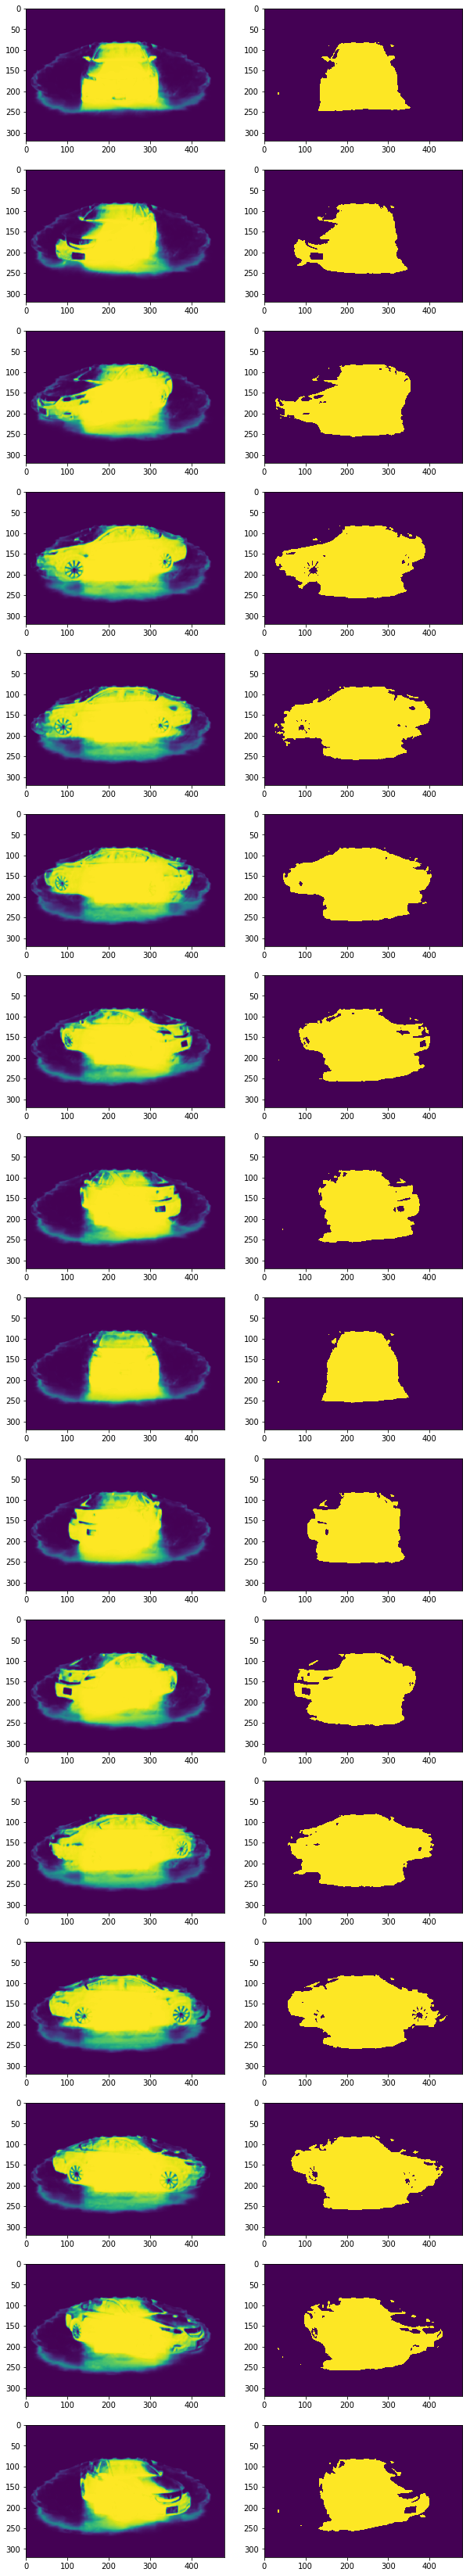

In [230]:
fig, ax = plt.subplots(16,2, figsize=(10, 60))
ax = ax.ravel()

for i in range(16):

    ax[2*i].imshow(y_pred[i])
    ax[2*i+1].imshow(np.where(y_pred[i] > 0.5, 1, 0))

In [232]:
file = open("naive_submission.csv", "w+")
file.write("img,  rle_mask\n")

num_test = 100

with tqdm_notebook(total=num_test) as bar:

    for i in ids_test[:num_test]:
        res = predict_img(prepare_img(i))
        for n, j in enumerate(imgs_idx):
            file.write('{}_{:02d}.jpg, {}\n'.format(i, j, res[n]))
            
        bar.update()

KeyboardInterrupt: 

In [ ]:
def encode_run_length(img):
    h, w = img.shape
    encoding = []
    for r in img:
        run = []
        is_car = False
        for i, p in enumerate(r):
            if p > 0.5:
                if is_car:
                    pass
                else: 
                    is_car = True
                    run.append(i)
            else:
                if is_car:
                    is_car = False
                    run.append(i)
                else:
                    pass
        # Final row
        if is_car:
            run.append(w)
            
        
                 